# 1. An Introduction to the Sensor Configuration for Data Gathering


The first step for point cloud processing is to get data from a 3D sensor. In this notebook, we show how to record data with realsense L515. We'll introduce two ways to record data (1) use native realsense SDK (2) use open3D realsense API


## 1.1  Record data with realsense SDK

Realsense SDK `pyrealsense2` is required. It can be easily installed by "pip install pyrealsense2". 

In [1]:
import pyrealsense2 as rs
import numpy as np
import cv2
import argparse
from os import makedirs
from os.path import exists, join
import shutil
import json
from enum import IntEnum
import matplotlib.pyplot as plt
%matplotlib inline

Helper functions

In [2]:
try:
    # Python 2 compatible
    input = raw_input
except NameError:
    pass


class Preset(IntEnum):
    Custom = 0
    Default = 1
    Hand = 2
    HighAccuracy = 3
    HighDensity = 4
    MediumDensity = 5


def make_clean_folder(path_folder):
    if not exists(path_folder):
        makedirs(path_folder)
    else:
        user_input = input("%s not empty. Overwrite? (y/n) : " % path_folder)
        if user_input.lower() == 'y':
            shutil.rmtree(path_folder)
            makedirs(path_folder)
        else:
            exit()


def save_intrinsic_as_json(filename, frame):
    intrinsics = frame.profile.as_video_stream_profile().intrinsics
    with open(filename, 'w') as outfile:
        obj = json.dump(
            {
                'width':
                    intrinsics.width,
                'height':
                    intrinsics.height,
                'intrinsic_matrix': [
                    intrinsics.fx, 0, 0, 0, intrinsics.fy, 0, intrinsics.ppx,
                    intrinsics.ppy, 1
                ]
            },
            outfile,
            indent=4)

Check if realsense sensor is connected

In [3]:
realsense_connected=False

context = rs.context()
if context.query_all_sensors():
    realsense_connected=True
    print("At least one realsensor is connected")

Set output path and make directories for output if realsense is connected

In [4]:
if realsense_connected:
    output_folder='../data/realsense/output'

    path_output = output_folder
    path_depth = join(output_folder, "depth")
    path_color = join(output_folder, "color")

    make_clean_folder(path_output)
    make_clean_folder(path_depth)
    make_clean_folder(path_color)


Configure realsense, set resolution and fps. 

In [5]:
depth_width=320
depth_height=240
color_width=640
color_height=480
fps=30

    
if realsense_connected:

    # Create a pipeline
    pipeline = rs.pipeline()

    #Create a config and configure the pipeline to stream
    #  different resolutions of color and depth streams
    config = rs.config()

    # note: using 640 x 480 depth resolution produces smooth depth boundaries
    #       using rs.format.bgr8 for color image format for OpenCV based image visualization
    config.enable_stream(rs.stream.depth, depth_width, depth_height, rs.format.z16, fps)
    config.enable_stream(rs.stream.color, color_width, color_height, rs.format.bgr8, fps)

    # Start streaming
    profile = pipeline.start(config)
    
    depth_sensor = profile.get_device().first_depth_sensor()

    # Using preset HighAccuracy for recording
    depth_sensor.set_option(rs.option.visual_preset, Preset.HighAccuracy)

    # Create an align object
    # rs.align allows us to perform alignment of depth frames to others frames
    # The "align_to" is the stream type to which we plan to align depth frames.
    align_to = rs.stream.color
    align = rs.align(align_to)


Streaming loop. 
Get depth and color data from realsense, then align them to the same size and show them in opencv. Press 'esc' to quit the loop.

In [6]:
if realsense_connected:
    frame_count = 0
    try:
        while True:
            # Get frameset of color and depth
            frames = pipeline.wait_for_frames()

            # Align the depth frame to color frame
            aligned_frames = align.process(frames)

            # Get aligned frames
            aligned_depth_frame = aligned_frames.get_depth_frame()
            color_frame = aligned_frames.get_color_frame()

            # Validate that both frames are valid
            if not aligned_depth_frame or not color_frame:
                continue

            depth_image = np.asanyarray(aligned_depth_frame.get_data())
            color_image = np.asanyarray(color_frame.get_data())

            # Save color and depth images to output folder
            if frame_count == 0:
                save_intrinsic_as_json(
                    join(output_folder, "camera_intrinsic.json"),
                    color_frame)
            cv2.imwrite("%s/%06d.png" % \
                    (path_depth, frame_count), depth_image)
            cv2.imwrite("%s/%06d.jpg" % \
                    (path_color, frame_count), color_image)
            print("Saved color + depth image %06d" % frame_count)
            frame_count += 1


            # Render images
            depth_colormap = cv2.applyColorMap(
                cv2.convertScaleAbs(depth_image, alpha=0.09), cv2.COLORMAP_JET)
            images = np.hstack((color_image, depth_colormap))

            cv2.namedWindow('Recorder Realsense', cv2.WINDOW_AUTOSIZE)
            cv2.imshow('Recorder Realsense', images)
            key = cv2.waitKey(1)

            # if 'esc' button pressed, escape loop and exit program
            if key == 27:
                cv2.destroyAllWindows()
                break
    finally:
        pipeline.stop()

## 1.2  Record data with Open3D python API

RealSense (`librealsense` SDK v2) is integrated into Open3D (v0.12+) and you can use it through both C++ and Python APIs without a separate `librealsense` SDK installation on Linux, macOS and Windows. 

Open3D can be easily installed by "pip install open3d"

In [7]:
import open3d as o3d
%matplotlib notebook
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


You can list all RealSense devices connected to the system and get their capabilities (supported resolutions, frame rates, etc.) with the code snippet below.

In [8]:
realsense_connected=o3d.t.io.RealSenseSensor.list_devices()
print('realsense_connected', realsense_connected)

[Open3D WARNING] No RealSense devices detected.
realsense_connected False


The following code snippets show how to capture live RGBD frames from a RealSense camera. They capture the first 5 frames and also save them to images.  

In [9]:
if realsense_connected:
    rscam = o3d.t.io.RealSenseSensor()
    rscam.start_capture()
    print(rscam.get_metadata())
    for fid in range(5):
        rgbd_frame = rscam.capture_frame()

        o3d.io.write_image(f"../data/realsense/color{fid:05d}.jpg",
                           rgbd_frame.color.to_legacy_image())
        o3d.io.write_image(f"../data/realsense/depth{fid:05d}.png",
                           rgbd_frame.depth.to_legacy_image())
        print("Frame: {}, time: {}s".format(fid, rscam.get_timestamp() * 1e-6))


    rscam.stop_capture()

Read in the first frame with open3d and create an RGBDImage from color and depth image.

In [10]:
color_raw = o3d.io.read_image("../data/realsense/pre_record/color00000.jpg")
depth_raw = o3d.io.read_image("../data/realsense/pre_record/depth00000.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw, convert_rgb_to_intensity=False)
print(rgbd_image)

RGBDImage of size 
Color image : 640x480, with 3 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


The converted images can be rendered as numpy arrays. You can check the depth value by moving cursor to a pixel. Note that depth value should be multiplied by 0.25 to get the real world depth in meter.

<IPython.core.display.Javascript object>


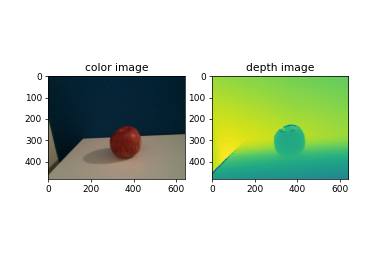

In [11]:
plt.subplot(1, 2, 1)
plt.title('color image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('depth image')
plt.imshow(rgbd_image.depth)
plt.show()

The RGBD image can be converted into a point cloud, given a set of camera parameters.

In [12]:
pinhole_camera_intrinsic = o3d.io.read_pinhole_camera_intrinsic(
    "../data/realsense/pre_record/camera_intrinsic.json")
print(pinhole_camera_intrinsic.intrinsic_matrix)

[[605.82086182   0.         322.85028076]
 [  0.         606.24249268 237.40437317]
 [  0.           0.           1.        ]]


In [13]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    pinhole_camera_intrinsic)
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])